In [8]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [9]:
qubo_path = "build/qubo_sparse.csv"      # change if needed
df_qubo = pd.read_csv(qubo_path)

print("Loaded QUBO with", len(df_qubo), "nonzero terms")

# Determine number of variables
n = int(max(df_qubo["i"].max(), df_qubo["j"].max()) + 1)
print("Detected QUBO size:", n, "variables")

Loaded QUBO with 86 nonzero terms
Detected QUBO size: 32 variables


In [12]:
job_arn = "arn:aws:braket:us-west-2:381305464630:job/aa634bf1-1804-404f-aef7-fee9698cfc1d"

from braket.aws import AwsQuantumJob
job = AwsQuantumJob(job_arn)

result = job.result()
counts = result["counts"]
counts


{'00011111101100011111100100011000': 1,
 '10011001100100010101000011100101': 1,
 '01001101101111010101101000011011': 1,
 '00101001101111001100101000111001': 1,
 '00101001011111111110110010111011': 1,
 '01000110001110101011111001001100': 1,
 '10001110101110010010000001111111': 1,
 '10111110101111011001100011110011': 1,
 '11001010000011100010001001110010': 1,
 '01111010100110110100001011011011': 1,
 '11101110101111100000001010000000': 1,
 '00011001111001000100101001000111': 1,
 '10011010011001001110000110011110': 1,
 '01101110110011100001001011111100': 1,
 '10101110110100000000011011000010': 1,
 '11111111011110101000100110000010': 1,
 '10010110001110101111011110000001': 1,
 '00001101101000010000000001000101': 1,
 '11001111110011110010110000000010': 1,
 '00110111000011001010111000001111': 1,
 '11001110111101111001011011100000': 1,
 '01100000000011001010100111010101': 1,
 '01101100110001110011010011110111': 1,
 '01100010001110111100000000110000': 1,
 '01001101011001011110111001111101': 1,


In [13]:
Q = np.zeros((n, n))

for _, row in df_qubo.iterrows():
    i, j, v = int(row["i"]), int(row["j"]), float(row["value"])
    Q[i, j] += v
    if i != j:
        Q[j, i] += v    # make symmetric

print("Dense QUBO matrix Q built with shape", Q.shape)

Dense QUBO matrix Q built with shape (32, 32)


In [14]:
def qubo_cost(bitstring, Q):
    """bitstring: string of 0/1 chars"""
    x = np.array([int(b) for b in bitstring])
    return float(x @ Q @ x)

In [15]:
energies = []
for bitstring, count in counts.items():
    if len(bitstring) != n:
        continue  # ignore malformed
    E = qubo_cost(bitstring, Q)
    energies.append((bitstring, E, count))

In [21]:
energies_sorted = sorted(energies, key=lambda t: t[1])

best_str, best_E, best_shots = energies_sorted[0]

print("\nBEST SOLUTION ")
print("Bitstring:", best_str)
print("Energy:", best_E)
print("Shots:", best_shots)


BEST SOLUTION 
Bitstring: 01000000000100010010000000000001
Energy: -20.0
Shots: 1


In [23]:
all_E = [e[1] for e in energies_sorted]

print("\nENERGY STATISTICS ")
print("Min energy:", np.min(all_E))
print("Max energy:", np.max(all_E))
print("Mean energy:", np.mean(all_E))
print("Median energy:", np.median(all_E))
print("Std dev:", np.std(all_E))


ENERGY STATISTICS 
Min energy: -20.0
Max energy: 248.0
Mean energy: 87.392
Median energy: 84.0
Std dev: 50.86844145440275


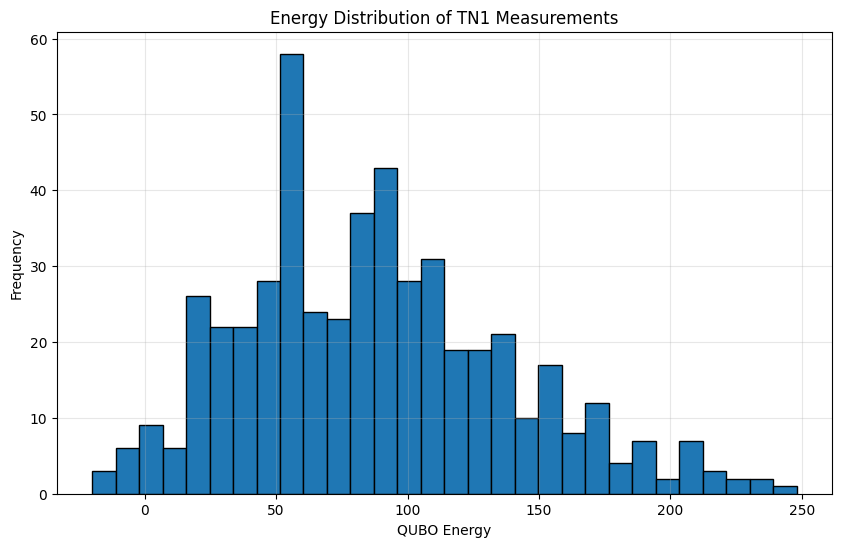

In [18]:
plt.figure(figsize=(10,6))
plt.hist(all_E, bins=30, edgecolor='black')
plt.xlabel("QUBO Energy")
plt.ylabel("Frequency")
plt.title("Energy Distribution of TN1 Measurements")
plt.grid(alpha=0.3)
plt.show()

In [20]:
k = 20
print(f"\nTOP {k} SOLUTIONS")
for i in range(min(k, len(energies_sorted))):
    s, E, c = energies_sorted[i]
    print(f"{i+1:02d}. E={E:.3f} | shots={c} | {s}")


TOP 20 SOLUTIONS
01. E=-20.000 | shots=1 | 01000000000100010010000000000001
02. E=-16.000 | shots=1 | 00011000100101000100000100010100
03. E=-12.000 | shots=1 | 00000001000100000100000000010000
04. E=-8.000 | shots=1 | 00010000110101000000100101100101
05. E=-4.000 | shots=1 | 10010110000010000011100100010001
06. E=-4.000 | shots=1 | 10010001100001000011100001010101
07. E=-4.000 | shots=1 | 01110000000111000100100000000110
08. E=-4.000 | shots=1 | 00011000010101010010001000010010
09. E=-4.000 | shots=1 | 11010001000100010001010101010101
10. E=0.000 | shots=1 | 10001000100111100000101100000001
11. E=0.000 | shots=1 | 00100100110101000010000101000010
12. E=0.000 | shots=1 | 10100010000110100101100100010110
13. E=0.000 | shots=1 | 01100100110000000000001101000100
14. E=4.000 | shots=1 | 00100010100100001100110100000110
15. E=4.000 | shots=1 | 10010001011101001010100100010110
16. E=4.000 | shots=1 | 10000001110100010001010100000110
17. E=4.000 | shots=1 | 10011011000100011100000101110101
1

In [39]:
df_raw = pd.read_csv("F24-Schedule-ECE.csv")

def parse_units(u):
    """
    Converts units to an integer:
    - '9' → 9
    - '0-3' → 3   (take max)
    - 'TBA' or missing → 0
    """
    if pd.isna(u):
        return 0

    u = str(u).strip()

    # example: "0-3"
    if "-" in u:
        parts = u.split("-")
        try:
            return int(parts[-1])  # take max part
        except:
            return 0

    # normal integer case
    try:
        return int(u)
    except:
        return 0

# Build unit_map
unit_map = (
    df_raw[["COURSE","UNITS"]]
    .drop_duplicates()
    .assign(UNITS=df_raw["UNITS"].apply(parse_units))
    .set_index("COURSE")["UNITS"]
    .to_dict()
)

# Convert COURSE keys to strings
unit_map = {str(k): int(v) for k, v in unit_map.items()}

print("Sample:", list(unit_map.items())[:10])


Sample: [('18021', 3), ('18050', 0), ('18095', 9), ('18100', 12), ('18200', 1), ('18202', 12), ('18213', 12), ('18220', 12), ('18240', 12), ('18290', 12)]


In [40]:
import json

with open("build/sections.json") as f:
    sections_list = json.load(f)


In [41]:
def evaluate_qaoa_solution(bitstring, sections_list, unit_map):
    """
    bitstring: string of 0/1 (length <= MAX_VARS)
    sections_list: list of dicts as created above
    unit_map: {course_code : units}
    """
    chosen = []
    total_units = 0
    
    for i, bit in enumerate(bitstring):
        if bit == "1":
            sec = sections_list[i]
            course = sec["course"]
            units = int(unit_map[str(course)])
            
            chosen.append({
                "course": course,
                "sec": sec["sec"],
                "units": units,
                "instructor": sec["instructor"],
                "room": sec["room"]
            })
            total_units += units

    return chosen, total_units


In [42]:
chosen, total_units = evaluate_qaoa_solution(best_str, sections_list, unit_map)

print("Max units from QAOA:", total_units)
for c in chosen:
    print(c)


Max units from QAOA: 40
{'course': '18021', 'sec': 'A2', 'units': 3, 'instructor': 'Bain, James', 'room': 'ANS B10'}
{'course': '18200', 'sec': 'A1', 'units': 1, 'instructor': 'Bain, James', 'room': 'DH 2210'}
{'course': '18202', 'sec': 'D', 'units': 12, 'instructor': 'Bhagavatula, Vijayakumar; Joe-Wong, Carlee', 'room': 'WEH 5312'}
{'course': '18213', 'sec': 'B', 'units': 12, 'instructor': 'Kesden, Gregory; Sekar, Vyas', 'room': 'WEH 5310'}
{'course': '18220', 'sec': 'Lec1', 'units': 12, 'instructor': 'Zajdel, Tom; Budnik, Mark', 'room': 'HOA 160'}
